In [2]:
import cv2
import numpy as np
import pandas as pd
import scipy
from scipy.misc import imread
import random
import os
import matplotlib.pyplot as plt
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from moviepy.editor import VideoFileClip
import shutil
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline

In [3]:
from util import *

In [4]:
IMAGES_DIR = 'test_images'

In [5]:
fnames = [os.path.join(IMAGES_DIR, fname) for fname in os.listdir(IMAGES_DIR)]
imnames = [fname for fname in os.listdir(IMAGES_DIR)]
images = [ cv2.imread(fname) for fname in fnames]
pil_images = [ Image.fromarray(img) for img in images]

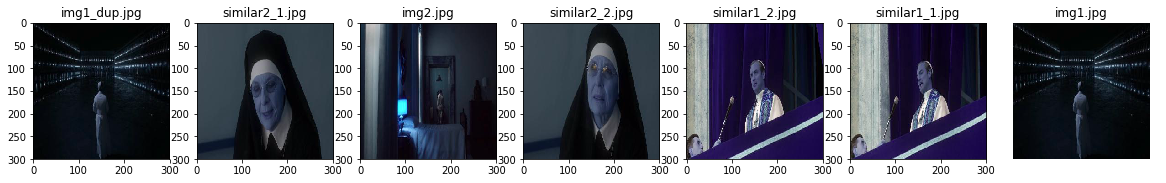

In [6]:
plt.figure(figsize=(20, 10))
i = 0
for img in images:
    plt.subplot(1, len(images), i+1)
    plt.title(imnames[i])
    plot_img(images[i])
    i+=1
plt.axis('off')
plt.show()

In [ ]:


def equalize_hist(img):
    img = np.array(img)
    for c in range(0, 2):
       img[:,:,c] = cv2.equalizeHist(img[:,:,c])
    return img

plot_img(equalize(images[0]))
plt.show()
plot_img(equalize_hist(images[0]))

In [ ]:
orb = np.vstack([extract_descriptors(np.array(image), extractor=cv2.ORB_create) for image in images])
orb

In [7]:
def pca_plot(vectors, labels):
    pca = PCA(n_components=2)
    X_r = pca.fit(vectors).transform(vectors)
    plt.figure()
    lw = 2

    for i in range(len(labels)):
        plt.scatter(X_r[i, 0], X_r[i, 1], alpha=.8, lw=lw, label=labels[i])
    plt.legend()
    plt.show()

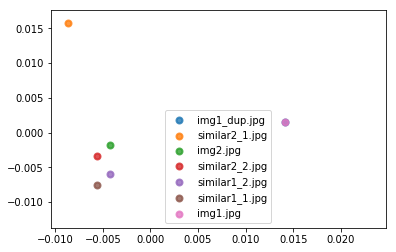

In [8]:
pca_plot(orb, imnames)

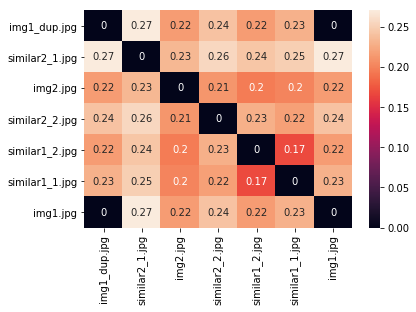

In [9]:
distances = scipy.spatial.distance.cdist(orb, orb, metric='cosine')   
sns.heatmap(distances, annot=True, xticklabels=imnames, yticklabels=imnames)

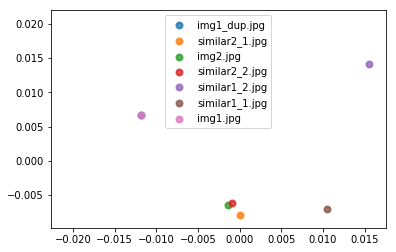

In [10]:
kaze = np.vstack([extract_descriptors(np.array(image), extractor=cv2.KAZE_create) for image in images])
pca_plot(kaze, imnames)

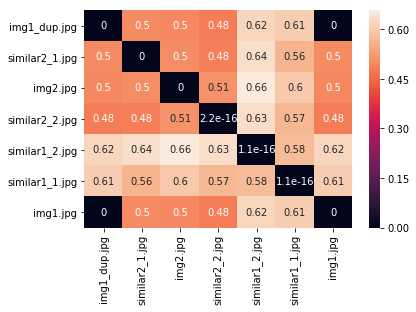

In [11]:
distances = scipy.spatial.distance.cdist(kaze, kaze, metric='cosine')   
sns.heatmap(distances, annot=True, xticklabels=imnames, yticklabels=imnames)

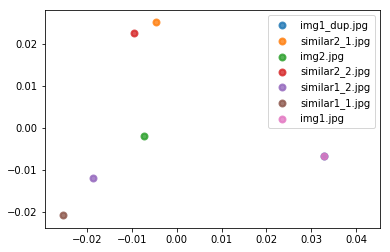

In [12]:
akaze = np.vstack([extract_descriptors(np.array(image), 5, extractor=cv2.AKAZE_create) for image in images])
pca_plot(akaze, imnames)

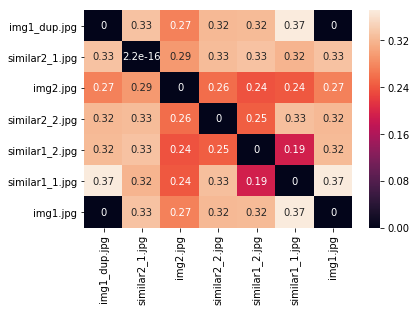

In [13]:
distances = scipy.spatial.distance.cdist(akaze, akaze, metric='cosine')
sns.heatmap(distances, annot=True, xticklabels=imnames, yticklabels=imnames)

In [14]:
# Color histograms

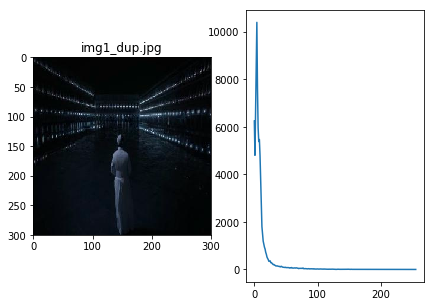

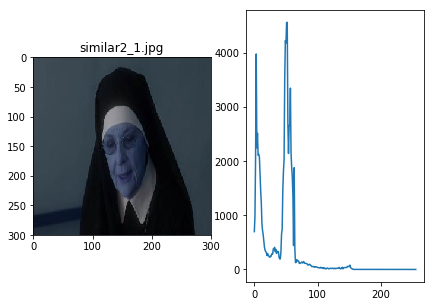

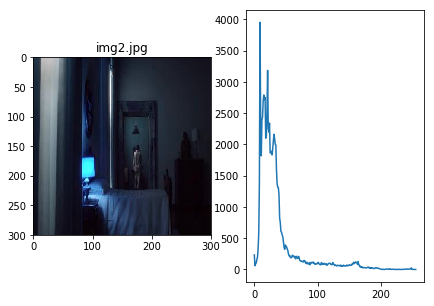

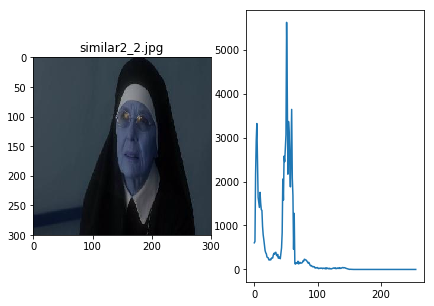

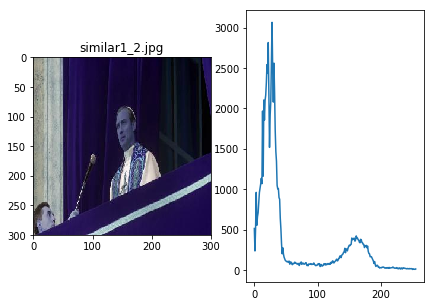

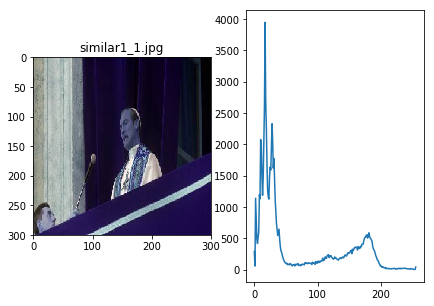

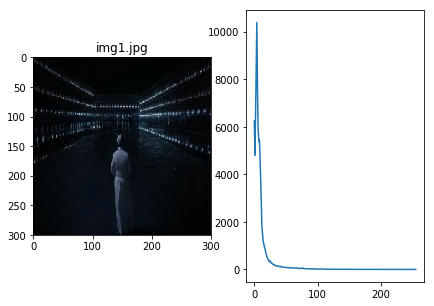

In [15]:
for i in range(0, len(imnames)):
    plt.figure(figsize=(7, 5))
    plt.subplot(1, 2, 1)
    plot_img(images[i])
    plt.title(imnames[i])
    plt.subplot(1, 2, 2)
    hist = cv2.calcHist([np.array(images[i])],[0],None,[256],[0,256])
    plt.plot(hist)
    plt.show()


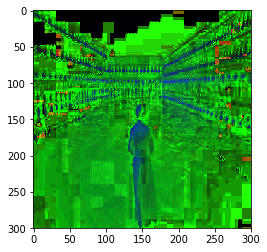

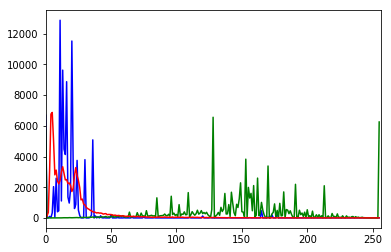

In [16]:
bins = [3, 3, 3]
img = cv2.cvtColor(np.array(images[0]), cv2.COLOR_BGR2HSV)

hist = cv2.calcHist([img], [0, 1, 2], None, bins,
        [0, 256, 0, 256, 0, 256])

def draw_image_histogram(image, channels, color='k'):
    hist = cv2.calcHist([image], channels, None, [256], [0, 256])
    plt.plot(hist, color=color)
    plt.xlim([0, 256])
    
def show_color_histogram(image):
    for i, col in enumerate(['b', 'g', 'r']):
        draw_image_histogram(image, [i], color=col)
    plt.show()

plot_img(img)
plt.show()
show_color_histogram(img)

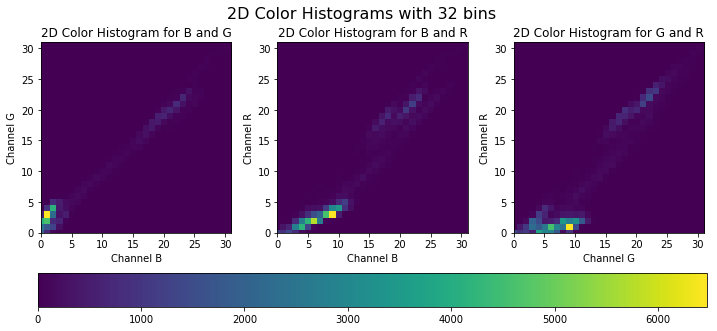

In [17]:
from matplotlib import ticker

def show_image_histogram_2d(image, bins=32, tick_spacing=5):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    channels_mapping = {0: 'B', 1: 'G', 2: 'R'}
    for i, channels in enumerate([[0, 1], [0, 2], [1, 2]]):
        hist = cv2.calcHist(
            [image], channels, None, [bins] * 2, [0, 256] * 2)

        channel_x = channels_mapping[channels[0]]
        channel_y = channels_mapping[channels[1]]

        ax = axes[i]
        ax.set_xlim([0, bins - 1])
        ax.set_ylim([0, bins - 1])

        ax.set_xlabel('Channel '+ channel_x)
        ax.set_ylabel('Channel '+ channel_y)
        ax.set_title('2D Color Histogram for %s and %s' % (channel_x, channel_y))

        ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

        im = ax.imshow(hist)

    fig.colorbar(im, ax=axes.ravel().tolist(), orientation='orizontal')
    fig.suptitle('2D Color Histograms with %d bins' % bins, fontsize=16)
    plt.show()
    
show_image_histogram_2d(np.array(images[4]))

In [18]:
features = local_histogram_features(np.array(images[3]), bins=[5, 5, 5])
print(features.shape)
print(pd.Series(features).describe())
features.sum()

(625,)
count    625.000000
mean       0.001600
std        0.011272
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.174476
dtype: float64


1.0

(7, 150)


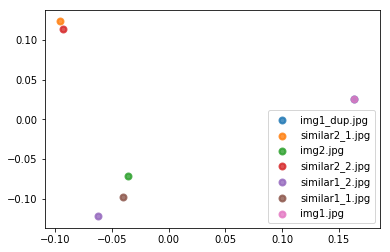

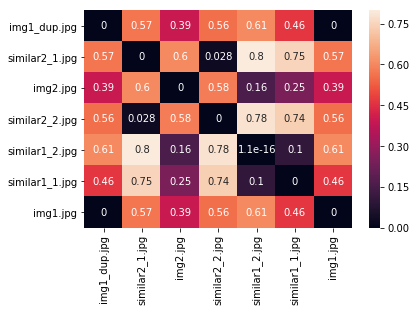

In [19]:
#bins = 256
grey_hist_features = np.vstack([gray_histogram_features(np.array(image)) for image in images])
print(grey_hist_features.shape)
pca_plot(grey_hist_features, imnames)
distances = scipy.spatial.distance.cdist(grey_hist_features, grey_hist_features, metric='cosine')
sns.heatmap(distances, annot=True, xticklabels=imnames, yticklabels=imnames)
plt.show()

(7, 2197)


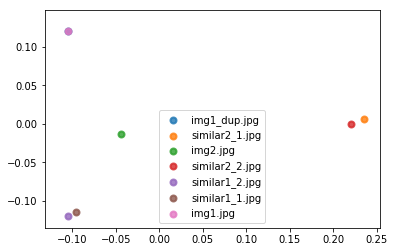

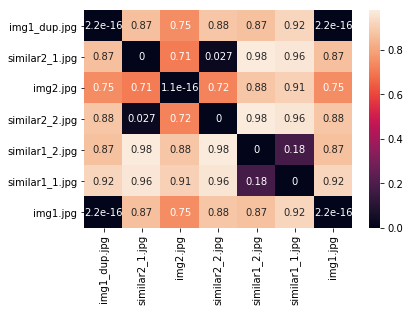

In [20]:
b = 13
bins = [b, b, b]
color_hist_features = np.vstack([color_histogram_features(np.array(image), bins=bins) for image in images])
print(color_hist_features.shape)
pca_plot(color_hist_features, imnames)
distances = scipy.spatial.distance.cdist(color_hist_features, color_hist_features, metric='cosine')
sns.heatmap(distances, annot=True, xticklabels=imnames, yticklabels=imnames)
plt.show()

(7, 1715)


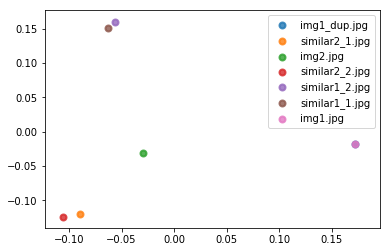

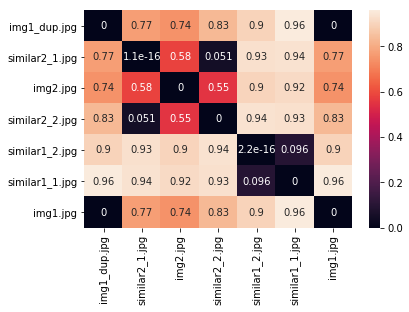

In [21]:
b = 7
bins = [b, b, b]
local_hist_features = np.vstack([local_histogram_features(np.array(image), bins=bins) for image in images])
print(local_hist_features.shape)
pca_plot(local_hist_features, imnames)
distances = scipy.spatial.distance.cdist(local_hist_features, local_hist_features, metric='cosine')
sns.heatmap(distances, annot=True, xticklabels=imnames, yticklabels=imnames)
plt.show()

(7, 625)


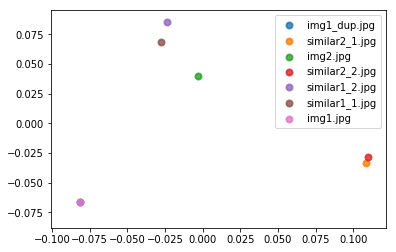

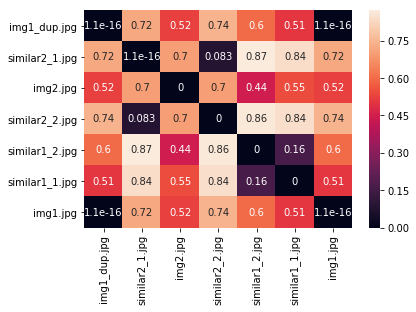

In [22]:
b = 125
bins = [b]
grey_local_hist_features = np.vstack([gray_local_histogram_features(np.array(image)) for image in images])
print(grey_local_hist_features.shape)
pca_plot(grey_local_hist_features, imnames)
distances = scipy.spatial.distance.cdist(grey_local_hist_features, grey_local_hist_features, metric='cosine')
sns.heatmap(distances, annot=True, xticklabels=imnames, yticklabels=imnames)
plt.show()

(7, 964)


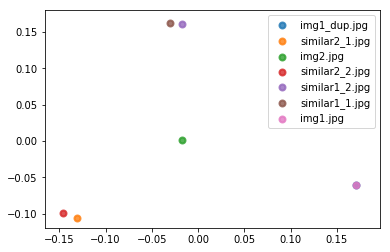

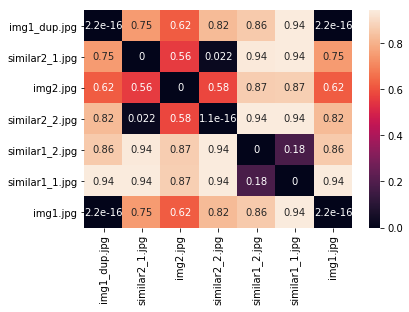

In [24]:
# Joint
bins = [5, 6, 6]
k_points = 2
joint_features = np.vstack([joint_feature_extractor(np.array(image), k_points=k_points, bins=bins) for image in images])
print(joint_features.shape)
pca_plot(joint_features, imnames)
distances = scipy.spatial.distance.cdist(joint_features, joint_features, metric='cosine')
sns.heatmap(distances, annot=True, xticklabels=imnames, yticklabels=imnames)
plt.show()

In [28]:
def preprocess_corrupt(image, params):
    image = image.resize((300, 300))
    image = restore_image(corrupt(image, *params))
    return image


cparams = random_corrupt_params()
def video_frame_corrupt(img):
    return preprocess_corrupt(img, cparams)

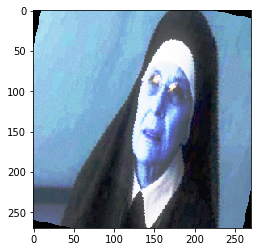

In [29]:
plot_img(video_frame_corrupt(pil_images[3]))